# F1 Final Position Prediction

This notebook predicts drivers’ finishing positions using a Random Forest model.

In [29]:
# Imports & Setup
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import warnings
import math
warnings.filterwarnings('ignore')

# Reproducibility
np.random.seed(42)

## Load Data

We read `data.csv`, inspect columns, and verify team names & circuit column.

In [34]:
df = pd.read_csv('../../data/data.csv')
print("Columns:", df.columns.tolist())
print("\nUnique teams:", df['team_name'].unique())
print("\nUnique circuits:", df['circuit'].unique())

Columns: ['team_name', 'driver_code', 'driver_nationality', 'circuit', 'year', 'round', 'starting_position', 'finishing_position', 'laps', 'qualifying_mean', 'driver_age', 'driver_dnf', 'car_dnf']

Unique teams: ['McLaren' 'Williams' 'Alpine F1 Team' 'RB F1 Team' 'Ferrari' 'Red Bull'
 'Aston Martin' 'Sauber' 'Mercedes' 'Manor Marussia' 'Caterham'
 'Haas F1 Team']

Unique circuits: ['albert_park' 'sepang' 'bahrain' 'catalunya' 'monaco' 'villeneuve'
 'silverstone' 'hockenheimring' 'hungaroring' 'spa' 'monza' 'marina_bay'
 'shanghai' 'interlagos' 'suzuka' 'yas_marina' 'rodriguez' 'ricard'
 'americas' 'red_bull_ring' 'sochi' 'baku' 'istanbul' 'imola' 'zandvoort'
 'portimao' 'jeddah' 'losail' 'miami' 'nurburgring' 'mugello' 'vegas']


## Features & Train/Test Split

- Target: `finishing_position`  
- Split by season: pre-2024 for training, 2024 for testing  
- Keep `year` only for split—exclude from features thereafter.

In [65]:
df.columns

Index(['team_name', 'driver_code', 'driver_nationality', 'circuit', 'year',
       'round', 'starting_position', 'finishing_position', 'laps',
       'qualifying_mean', 'driver_age', 'driver_dnf', 'car_dnf'],
      dtype='object')

In [77]:
cat_feats = ['team_name','driver_code','driver_nationality','circuit']
num_feats = ['round','starting_position','laps','qualifying_mean','driver_age','driver_dnf','car_dnf']

full_preprocessor = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), cat_feats),
    ('sca', StandardScaler(), num_feats)
], remainder='passthrough')

In [78]:
# Define X/y
X = df.drop(columns=['finishing_position'])
X = full_preprocessor.fit_transform(X)
X = pd.DataFrame(X)
print()
y = df['finishing_position']

# Year-based split
train = df[df['year'] < 2024]
test  = df[df['year'] == 2024]

X_train = train.drop(columns=['finishing_position'])
y_train = train['finishing_position']
X_test  = test.drop(columns=['finishing_position'])
y_test  = test['finishing_position']

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (4121, 12) Test shape: (479, 12)


AttributeError: 'numpy.ndarray' object has no attribute 'head'

## Preprocessing Pipeline

We’ll one-hot encode four categorical features and scale seven numeric ones.

In [23]:
cat_feats = ['team_name','driver_code','driver_nationality','circuit']
num_feats = ['round','starting_position','laps','qualifying_mean','driver_age','driver_dnf','car_dnf']

full_preprocessor = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first', sparse_output=False), cat_feats),
    ('sca', StandardScaler(), num_feats)
])

## Backward Elimination by Feature Group

We drop entire features (numeric or all dummies of a categorical) if they fail an ANOVA F-test (p > 0.05).  
After dropping, we remove them from our feature_groups dict for efficiency.

In [28]:
# 1) Build statsmodels design matrix
X_be = pd.get_dummies(X_train.drop(columns=['year']), drop_first=True)
X_be = sm.add_constant(X_be).astype(float)
y_num = y_train.astype(float)

#####
X_test_be = pd.get_dummies(X_test.drop(columns=['year']), drop_first=True)
X_test_be = sm.add_constant(X_test_be).astype(float)
X_test_be = X_test_be.copy()

#####
print(X_be.shape)
print(X_test_be.shape)


# 2) Map each original feature to its columns
feature_groups = {}
for f in num_feats:
    feature_groups[f] = [f]
for f in cat_feats:
    feature_groups[f] = [c for c in X_be.columns if c.startswith(f + '_')]

# 3) Iteratively drop groups
SL = 0.05
X_curr = X_be.copy()
step = 1

while True:
    full_mod = sm.OLS(y_num, X_curr).fit()
    pvals = {}
    for feat, cols in feature_groups.items():
        # skip already-removed
        if any(c not in X_curr.columns for c in cols):
            continue
        X_red = X_curr.drop(columns=cols)
        red_mod = sm.OLS(y_num, X_red).fit()
        anova = sm.stats.anova_lm(red_mod, full_mod)
        pvals[feat] = anova['Pr(>F)'][1]
    worst_feat, worst_p = max(pvals.items(), key=lambda x: x[1])
    if worst_p > SL:
        # drop group and remove from dict
        print(f"Step {step}: drop {worst_feat!r} (p={worst_p:.3f})")
        X_curr = X_curr.drop(columns=feature_groups[worst_feat])

        ###
        X_test_be = X_test_be.drop(columns=feature_groups[worst_feat])

        del feature_groups[worst_feat]
        step += 1
    else:
        print("No more features with p > 0.05; stopping.")
        break

selected_cols = X_curr.columns.tolist()
print("Selected columns:", selected_cols)

(4121, 126)
(479, 79)
Step 1: drop 'round' (p=0.503)
Step 2: drop 'driver_nationality' (p=0.067)


KeyError: "['driver_nationality_Belgian', 'driver_nationality_Brazilian', 'driver_nationality_Indonesian', 'driver_nationality_Italian', 'driver_nationality_Polish', 'driver_nationality_Russian', 'driver_nationality_Swedish', 'driver_nationality_Venezuelan'] not found in axis"

In [14]:
# 1) Build statsmodels design matrix
X_test_be = pd.get_dummies(X_test.drop(columns=['year']), drop_first=True)
X_test_be = sm.add_constant(X_test_be).astype(float)

## Random Forest: Hyperparameter Tuning & Evaluation

We tune `n_estimators`, `max_depth`, and `min_samples_leaf` using 5-fold CV optimizing R².  
We then evaluate on the hold-out test set, reporting R², RMSE, and MAE.

In [6]:
# 6. Fit & Evaluate Random Forest on Selected Features

# 6.1. Determine exactly which original feature‐groups survived elimination
survived = [
    feat
    for feat, cols in feature_groups.items()
    if all(col in X_curr.columns for col in cols)
]
sel_cat = [f for f in survived if f in cat_feats]
sel_num = [f for f in survived if f in num_feats]

print("Using categorical:", sel_cat)
print("Using numerical:  ", sel_num)

# 6.2. Build reduced preprocessor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose        import ColumnTransformer
from sklearn.pipeline       import Pipeline
from sklearn.ensemble       import RandomForestRegressor
from sklearn.metrics        import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

ct_sel = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), sel_cat),
    ('sca', StandardScaler(), sel_num)
])

# 6.3. Random Forest Pipeline
rf_pipe = Pipeline([
    ('preprocessor', ct_sel),
    ('regressor', RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ))
])

# 6.4. Fit on the 2024‐split training data
Xtr_sel = X_train[sel_cat + sel_num]
Xte_sel = X_test[ sel_cat + sel_num]

rf_pipe.fit(Xtr_sel, y_train)

# 6.5. Predict & evaluate
y_pred = rf_pipe.predict(Xte_sel)
r2   = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Random Forest Regressor | MAE = {mae:.3f} | R² = {r2:.3f} | RMSE = {rmse:.3f}")

Using categorical: ['team_name', 'driver_code', 'circuit']
Using numerical:   ['starting_position', 'laps', 'driver_age', 'driver_dnf', 'car_dnf']
Random Forest Regressor | MAE = 2.309 | R² = 0.715 | RMSE = 3.072


In [6]:
## Adding Ranked Metrics Below

In [13]:
#reattach for knowing ranks
test['pred_rf'] = y_pred
test['finishing_position'] = y_test

#converting to ranks
test['actual_rank'] = test.groupby('circuit')['finishing_position'].rank(method='min')
test['rf_rank'] = test.groupby('circuit')['pred_rf'].rank(method='min')

#updated rank calcs
mae = mean_absolute_error(test['actual_rank'], test['rf_rank'])
r2 = r2_score(test['actual_rank'], test['rf_rank'])
rsme = np.sqrt((mean_squared_error(test['actual_rank'], test['rf_rank'])))

print("Ranked MAE:", mae)
print("Ranked R²:", r2)
print("Ranked RMSE:", rsme)

Ranked MAE: 2.1816283924843423
Ranked R²: 0.6984793830707543
Ranked RMSE: 3.1606267711703686


# Create a comparison table

In [30]:
# 1) Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Team':        test['team_name'].values,
    'Circuit':     test['circuit'].values,
    'Actual Pos':  y_test.values,
    'Predicted Pos': y_pred
})

# 2) Show the first few rows
print(comparison_df.head(10))

      Team      Circuit  Actual Pos  Predicted Pos
0  McLaren  albert_park         3.0           3.65
1  McLaren      bahrain         6.0           6.27
2  McLaren    catalunya         2.0           4.21
3  McLaren       monaco         4.0           4.10
4  McLaren   villeneuve         2.0           3.82
5  McLaren  silverstone         3.0           3.76
6  McLaren  hungaroring         2.0           4.41
7  McLaren          spa         5.0           4.52
8  McLaren        monza         3.0           4.31
9  McLaren   marina_bay         1.0           4.01


# Visualization

Actual vs. Predicted plot for Random Forest model.

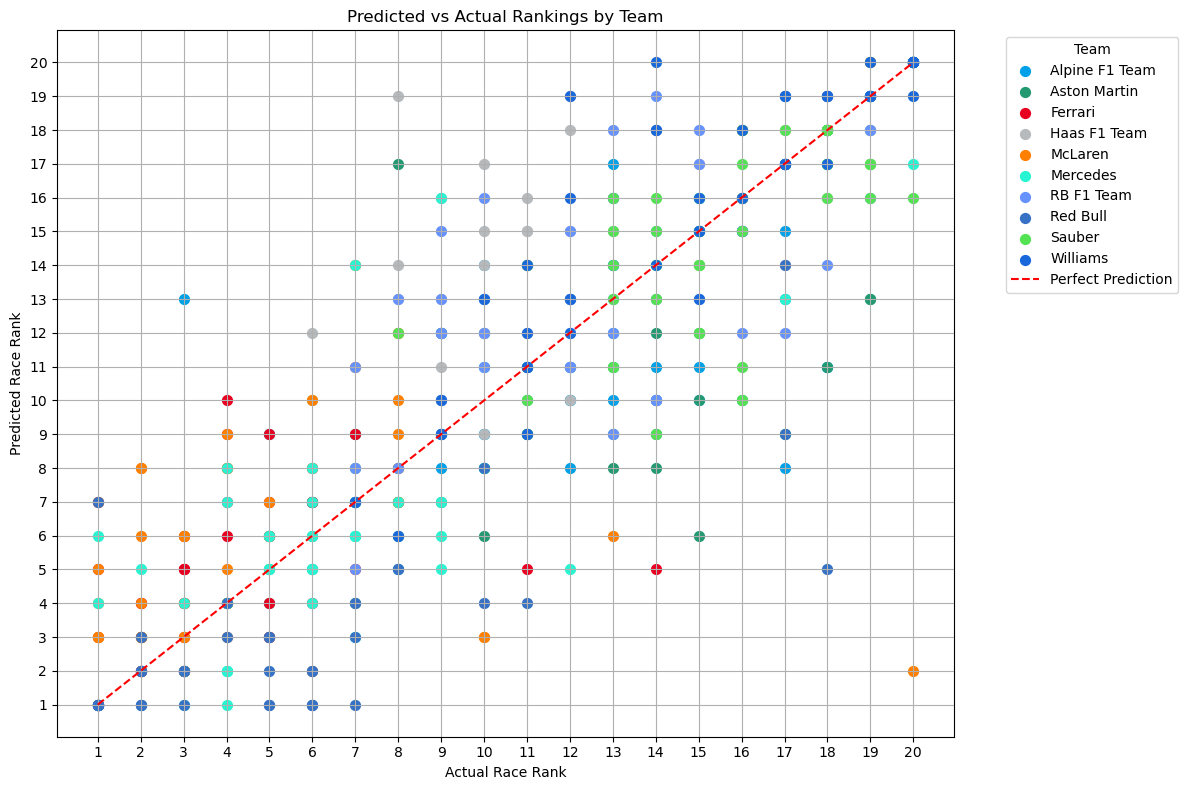

In [32]:
# 1) Reconstruct test DataFrame for plotting
plot_df = test.copy()
plot_df['y_pred'] = y_pred
plot_df['y_true'] = y_test.values

# 2) Compute ranks within each circuit
plot_df['actual_rank']    = plot_df.groupby('circuit')['y_true'].rank(method='min')
plot_df['predicted_rank'] = plot_df.groupby('circuit')['y_pred'].rank(method='min')

# 3) Define your team colors
team_colors = {
    'Mercedes':        '#27F4D2',
    'Red Bull':        '#3671C6',
    'Ferrari':         '#E80020',
    'McLaren':         '#FF8000',
    'Alpine F1 Team':  '#00A1E8',
    'RB F1 Team':      '#6692FF',
    'Aston Martin':    '#229971',
    'Williams':        '#1868DB',
    'Sauber':          '#52E252',
    'Haas F1 Team':    '#B6BABD'
}

# 4) Plot
plt.figure(figsize=(12, 8))
max_rank = int(max(plot_df['actual_rank'].max(), plot_df['predicted_rank'].max()))

for team, grp in plot_df.groupby('team_name'):
    plt.scatter(
        grp['actual_rank'],
        grp['predicted_rank'],
        label=team,
        color=team_colors.get(team, '#888888'),
        s=50
    )

# Perfect prediction reference line
plt.plot([1, max_rank], [1, max_rank], 'r--', label='Perfect Prediction')

# Tick marks at every integer
plt.xticks(range(1, max_rank + 1))
plt.yticks(range(1, max_rank + 1))

# Labels and styling
plt.xlabel('Actual Race Rank')
plt.ylabel('Predicted Race Rank')
plt.title('Predicted vs Actual Rankings by Team')
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Starting vs Actual (o) and Predicted (×) Finishing Positions by Team

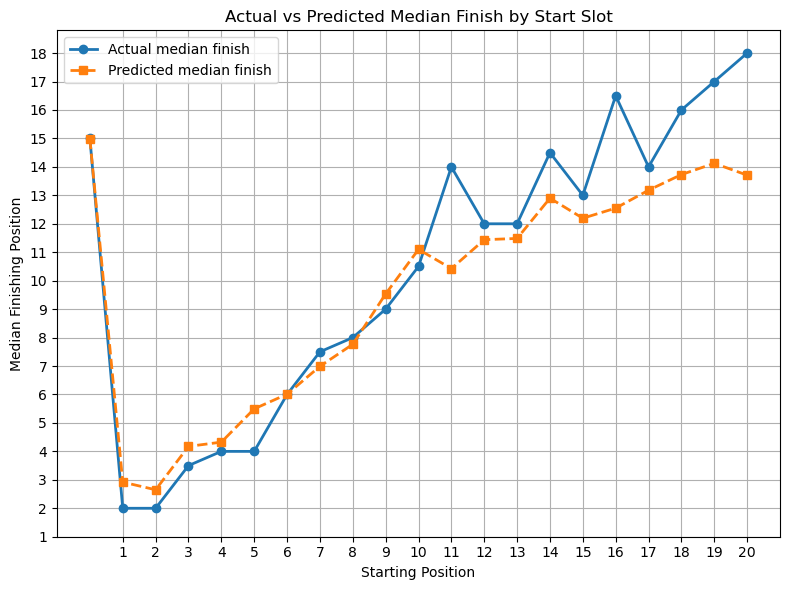

In [33]:
# 1) Compute medians by starting position
agg = plot_df.groupby('starting_position').agg(
    actual_med   = ('y_true', 'median'),
    predicted_med= ('y_pred', 'median')
).reset_index()

# 2) Plot both curves
plt.figure(figsize=(8,6))
plt.plot(
    agg['starting_position'],
    agg['actual_med'],
    marker='o',
    linewidth=2,
    label='Actual median finish'
)
plt.plot(
    agg['starting_position'],
    agg['predicted_med'],
    marker='s',
    linestyle='--',
    linewidth=2,
    label='Predicted median finish'
)

# 3) Ticks at every integer
max_pos = int(agg['starting_position'].max())
plt.xticks(range(1, max_pos+1))
plt.yticks(range(1, int(max(agg['actual_med'].max(), agg['predicted_med'].max()))+1))

# 4) Labels & styling
plt.xlabel('Starting Position')
plt.ylabel('Median Finishing Position')
plt.title('Actual vs Predicted Median Finish by Start Slot')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Race-by-Race: Actual vs. Predicted Driver Rankings by Team

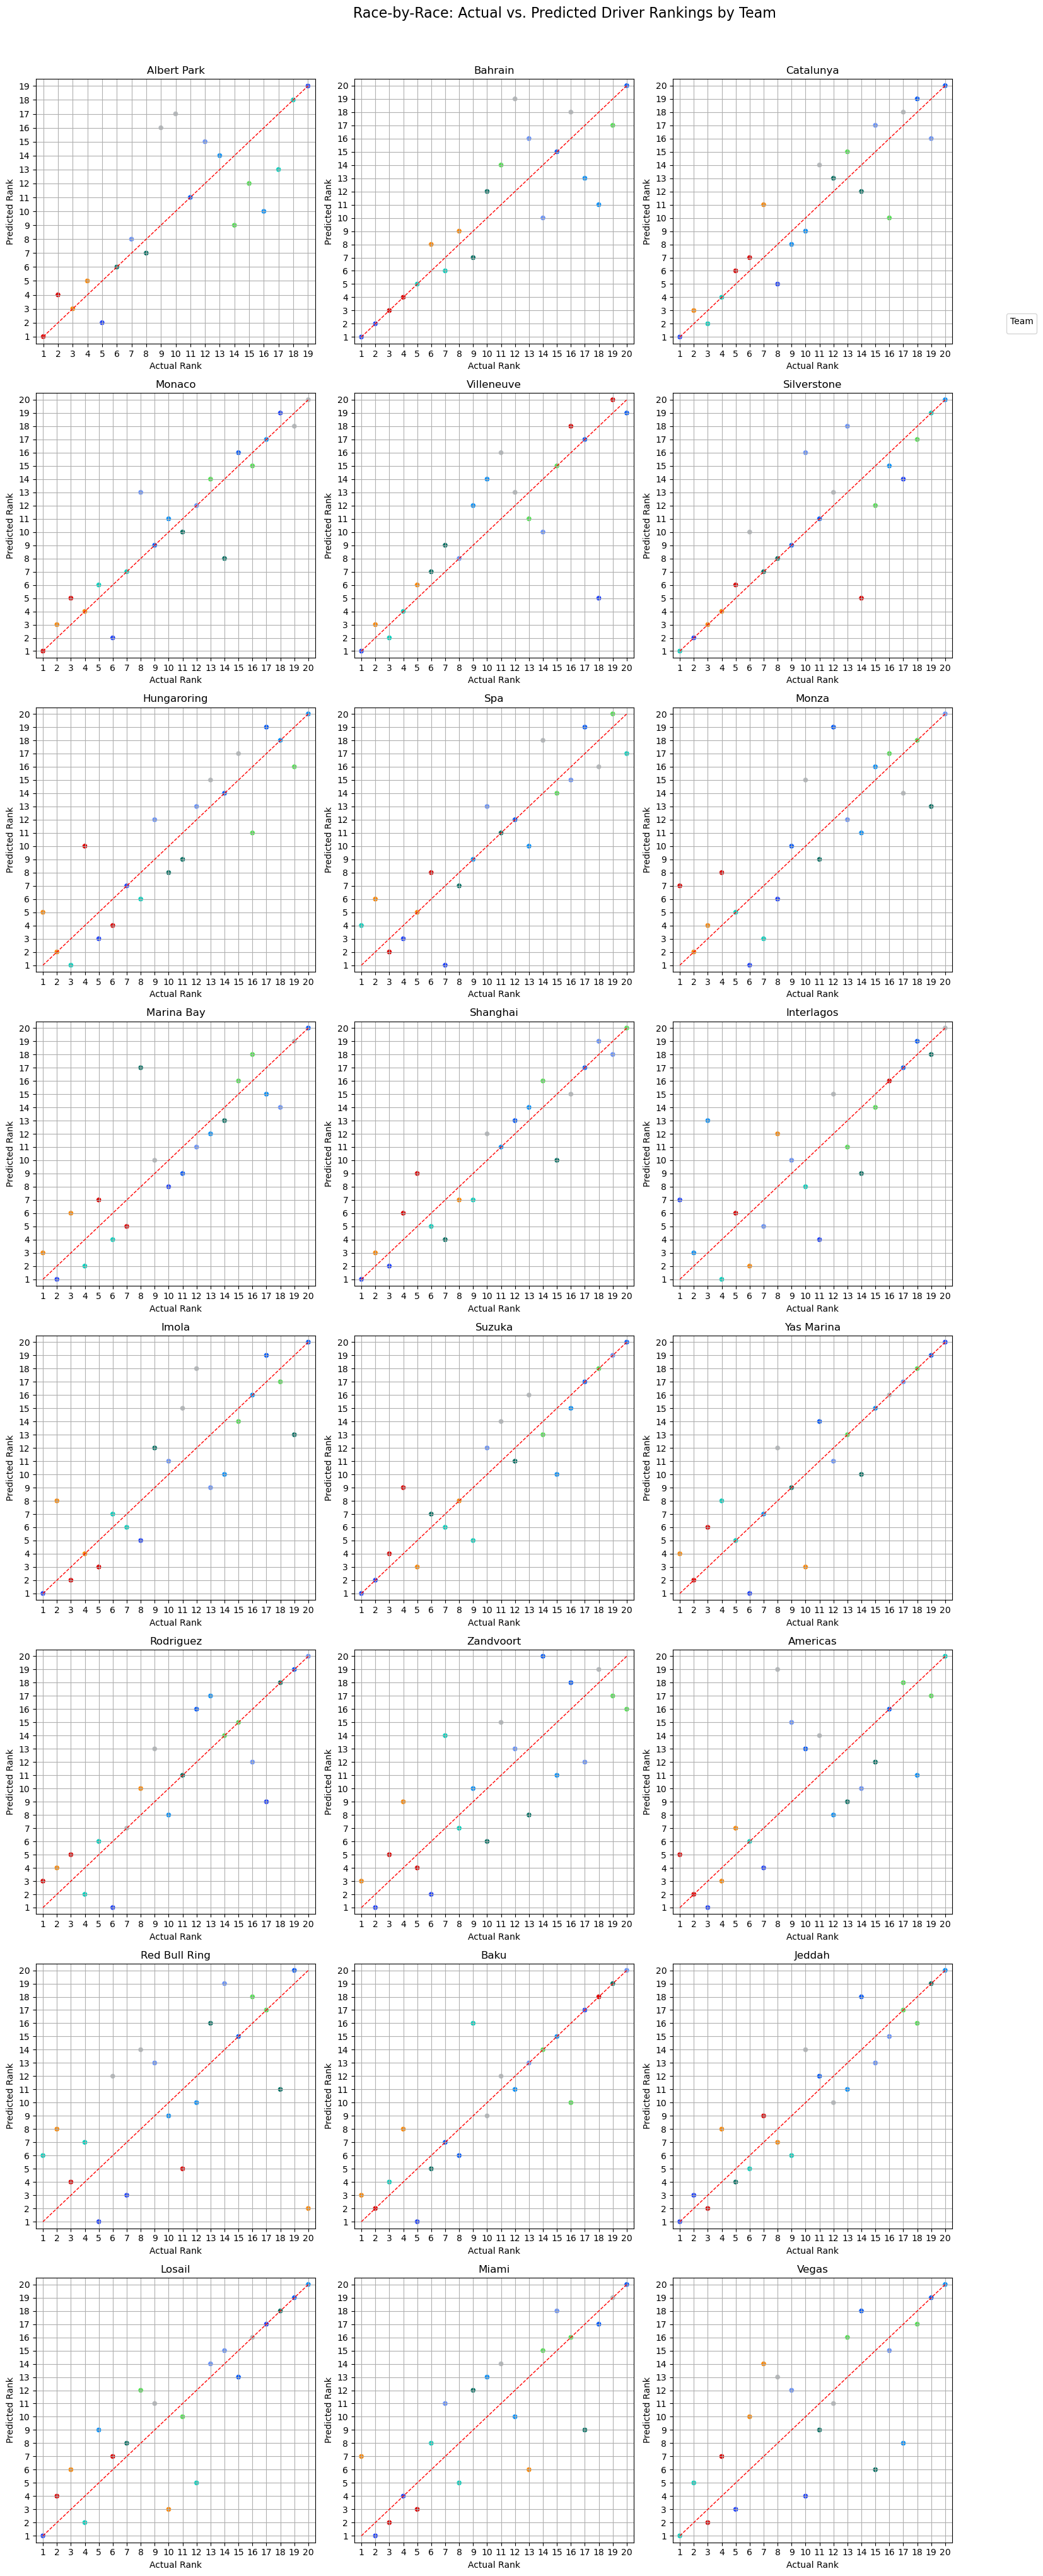

In [37]:
test = test.copy()
test['y_pred'] = y_pred

# compute true & predicted ranks by circuit
test['actual_rank']    = test.groupby('circuit')['finishing_position']\
                             .rank(method='min')
test['predicted_rank'] = test.groupby('circuit')['y_pred']\
                             .rank(method='min')

# Team colors (fallback gray for any others)
team_colors = {
    'Red Bull':        '#1E41FF',
    'Mercedes':        '#00D2BE',
    'Ferrari':         '#DC0000',
    'McLaren':         '#FF8700',
    'Aston Martin':    '#006F62',
    'Alpine F1 Team':  '#0090FF',
    'Williams':        '#005AFF',
    'RB F1 Team':      '#6692FF',
    'Haas F1 Team':    '#B6BABD',
    'Sauber':          '#52E252'
}
present = test['team_name'].unique()
palette = {team: team_colors.get(team, '#888888') for team in present}

# Unique circuits
races  = test['circuit'].unique()
n_r   = len(races)
cols  = 3
rows  = math.ceil(n_r / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
axes = axes.flatten()

for ax, race in zip(axes, races):
    rd = test[test['circuit'] == race]
    sns.scatterplot(
        x='actual_rank',
        y='predicted_rank',
        hue='team_name',
        data=rd,
        ax=ax,
        palette=palette,
        legend=False
    )
    # perfect-prediction line
    m = int(max(rd['actual_rank'].max(), rd['predicted_rank'].max()))
    ax.plot([1, m], [1, m], 'r--', linewidth=1)
    # integer ticks
    ax.set_xticks(range(1, m+1))
    ax.set_yticks(range(1, m+1))
    ax.set_xlim(0.5, m+0.5)
    ax.set_ylim(0.5, m+0.5)
    ax.set_title(race.replace('_',' ').title())
    ax.set_xlabel('Actual Rank')
    ax.set_ylabel('Predicted Rank')
    ax.grid(True)

# remove any empty subplots
for ax in axes[n_r:]:
    fig.delaxes(ax)

# global formatting
fig.tight_layout(rect=[0, 0, 0.85, 1])
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Team', loc='upper right', bbox_to_anchor=(0.92, 0.9))
fig.suptitle('Race-by-Race: Actual vs. Predicted Driver Rankings by Team', fontsize=16, y=1.02)
plt.show()

Constructor Championship Points: Actual vs. Predicted

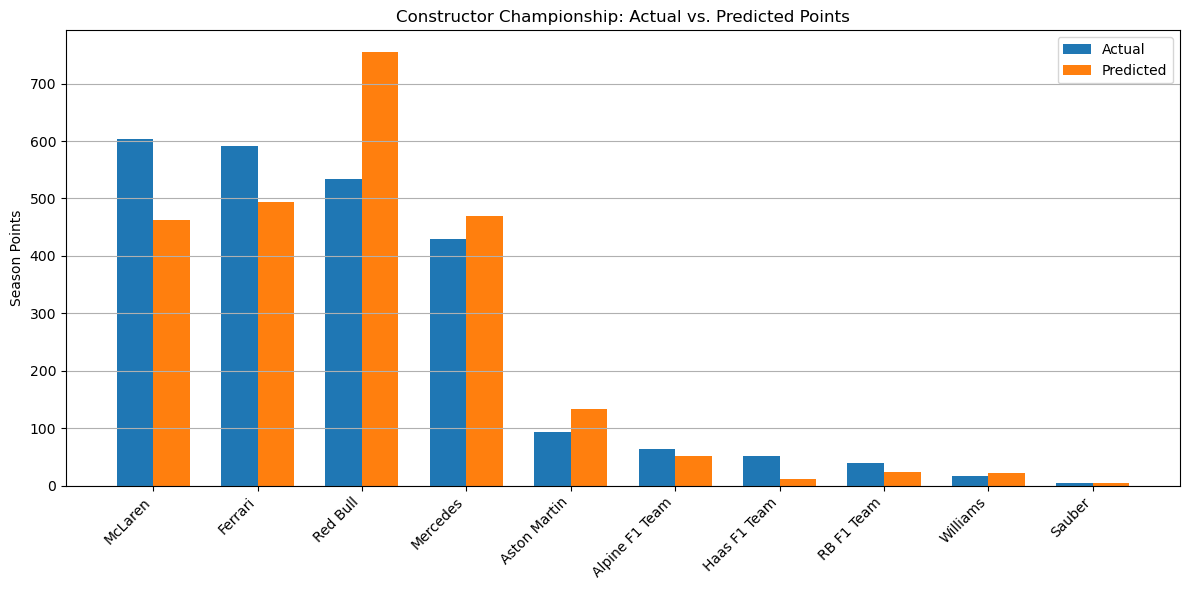

        team_name  actual_points  predicted_points
4         McLaren            603               463
2         Ferrari            591               493
7        Red Bull            533               755
5        Mercedes            429               469
1    Aston Martin             93               133
0  Alpine F1 Team             63                52
3    Haas F1 Team             51                11
6      RB F1 Team             40                24
9        Williams             17                21
8          Sauber              4                 5


In [38]:
# 1) Define the standard F1 points map
def position_to_points(pos):
    points_map = {
         1: 25,  2: 18,  3: 15,  4: 12,  5: 10,
         6:  8,  7:  6,  8:  4,  9:  2, 10:  1
    }
    return points_map.get(int(pos), 0)

# 2) Compute points per driver
test = test.copy()
test['actual_points']    = test['actual_rank'].apply(position_to_points)
test['predicted_points'] = test['predicted_rank'].apply(position_to_points)

# 3) Sum points by team & circuit, then total per team
team_race_points = (
    test
    .groupby(['team_name', 'circuit'])
    .agg(actual_points   = ('actual_points', 'sum'),
         predicted_points= ('predicted_points', 'sum'))
    .reset_index()
)

season_totals = (
    team_race_points
    .groupby('team_name')
    .agg(actual_points    = ('actual_points', 'sum'),
         predicted_points = ('predicted_points', 'sum'))
    .reset_index()
    .sort_values('actual_points', ascending=False)
)

# 4) Plot actual vs. predicted totals
teams = season_totals['team_name']
x     = np.arange(len(teams))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, season_totals['actual_points'],    width, label='Actual')
ax.bar(x + width/2, season_totals['predicted_points'], width, label='Predicted')

ax.set_xticks(x)
ax.set_xticklabels(teams, rotation=45, ha='right')
ax.set_ylabel('Season Points')
ax.set_title('Constructor Championship: Actual vs. Predicted Points')
ax.legend()
ax.grid(axis='y')

plt.tight_layout()
plt.show()

# 5) Display the underlying data
print(season_totals)